# **Classification model: Adult Data Set**
#### Abstract:
Predict whether income exceeds $50K/yr based on US census data. Also known as "Census Income" dataset. 

https://archive.ics.uci.edu/ml/datasets/adult


#**Imports and functions**

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import math
import matplotlib.pyplot as plt 

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabaz_score

%matplotlib inline
# ignore all warnings
import warnings
warnings.simplefilter("ignore")

In [2]:
def confusionMatrix(y_test, y_pred):
    """ 
    Returns the confusion matrix plot and the confusion matrix dataframe.

    Parameters:
        y_test: dataframe with the real data labels.
        y_pred: dataframe with the predicted data labels.
    Returns:
        data_cm: Dataframe of the confusion matrix result.   

    """
    cm = confusion_matrix(y_test, y_pred)
    data_cm = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
    data_cm.index.name = 'Actual'
    data_cm.columns.name = 'Predicted'

    sns.set(font_scale=1.4)
    fig, ax = plt.subplots(figsize=(12,6))

    sns.heatmap(data_cm, cmap="Blues", annot=True, fmt='', ax=ax)
    return data_cm

In [3]:
def distributionPlot(data, columnNumber):
    """ 
    Generates the distribution plot for the given data.

    Parameters:
        data: dataframe with the data to plot.
        columNumber: Number of columns the plot will return.

    """
    data_columns = data.columns.values
    #data_columns = data._get_numeric_data().columns.values
    plot_columns = columnNumber
    number_of_columns = math.ceil(len(data_columns)/plot_columns)
    number_of_rows = math.ceil((len(data_columns))/number_of_columns)

    plt.figure(figsize=(16,22))

    # plot distribution
    for i in range(0, len(data_columns)):
        plt.subplot(number_of_columns + 1, number_of_rows, i+1)
        sns.distplot(data[data_columns[i]], kde=True) 

#**Reading data**

In [73]:
df_train = pd.read_csv('adult_train.csv')
df_train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educationNum',
       'maritalStatus', 'occupation', 'relationship', 'race', 'sex',
       'capitalGain', 'capitalLoss', 'hoursWeek', 'nativeCountry', 'target'],
      dtype='object')

In [74]:
df_train.head()

,age,workclass,fnlwgt,education,educationNum,maritalStatus,occupation,relationship,race,sex,capitalGain,capitalLoss,hoursWeek,nativeCountry,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


#**Data Transformation**

The relevant data exploration process (pre-processing, feature extraction/selection, clustering
and visualization) 
1. treatment of lost values (missing values)
2. treatment of anomalous values (outliers)
3. treatment of incoherent or incorrect values
4. coding of non-continuous or non-ordered variables (nominal or binary)
5. possible elimination of irrelevant or redundant variables (feature selection)
6. creation of new variables that can be useful (feature extraction)
7. normalization of the variables (e.g. standardization)
8. transformation of the variables (e.g. correction of serious skewness and/or kurtosis)

## Treatment of lost values (missing values)

Out testing dataset doesn't have missing values but on further inspection the unknown values have been replaced with a " ?" when there's a missing value. So we are going to use pandas replace_to para reemplazarlo con NaN y que podamos hacer algo con esos values. https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html

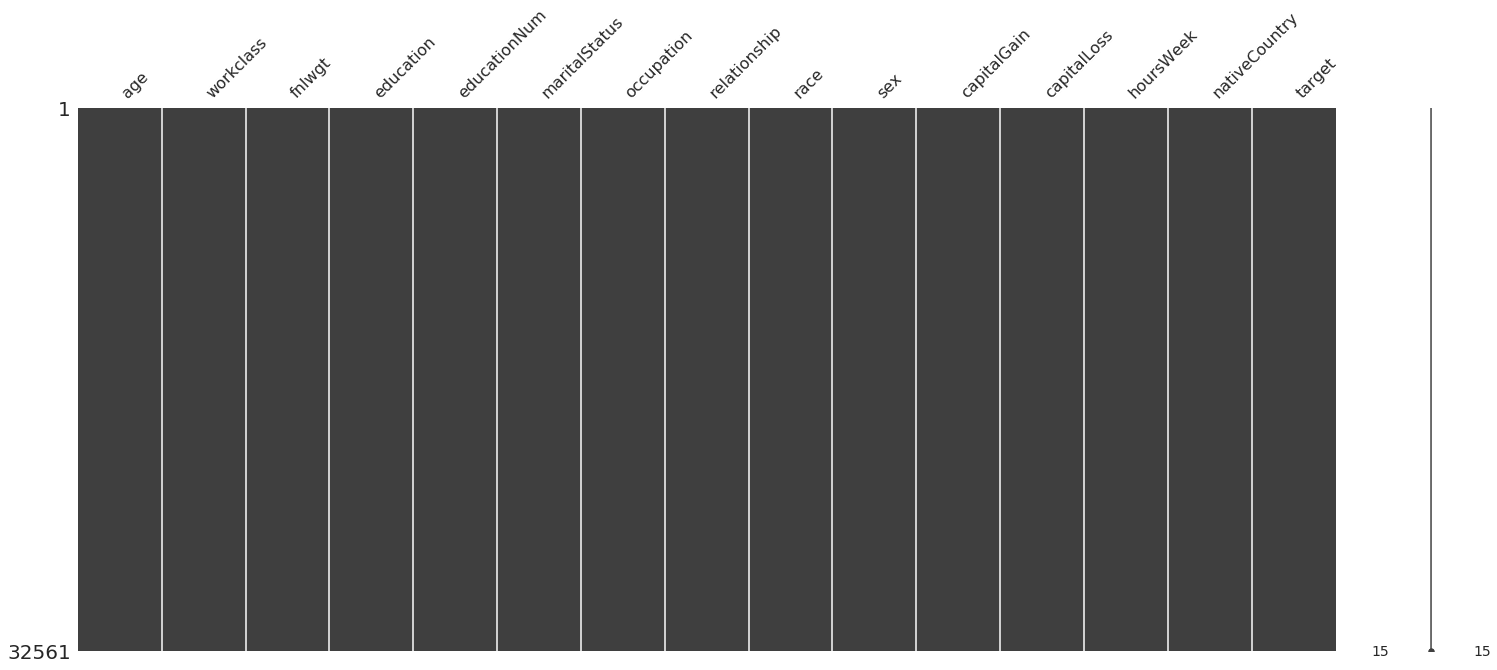

In [75]:
msno.matrix(df_train)

In [76]:
df_train = df_train.replace(' ?', np.nan)

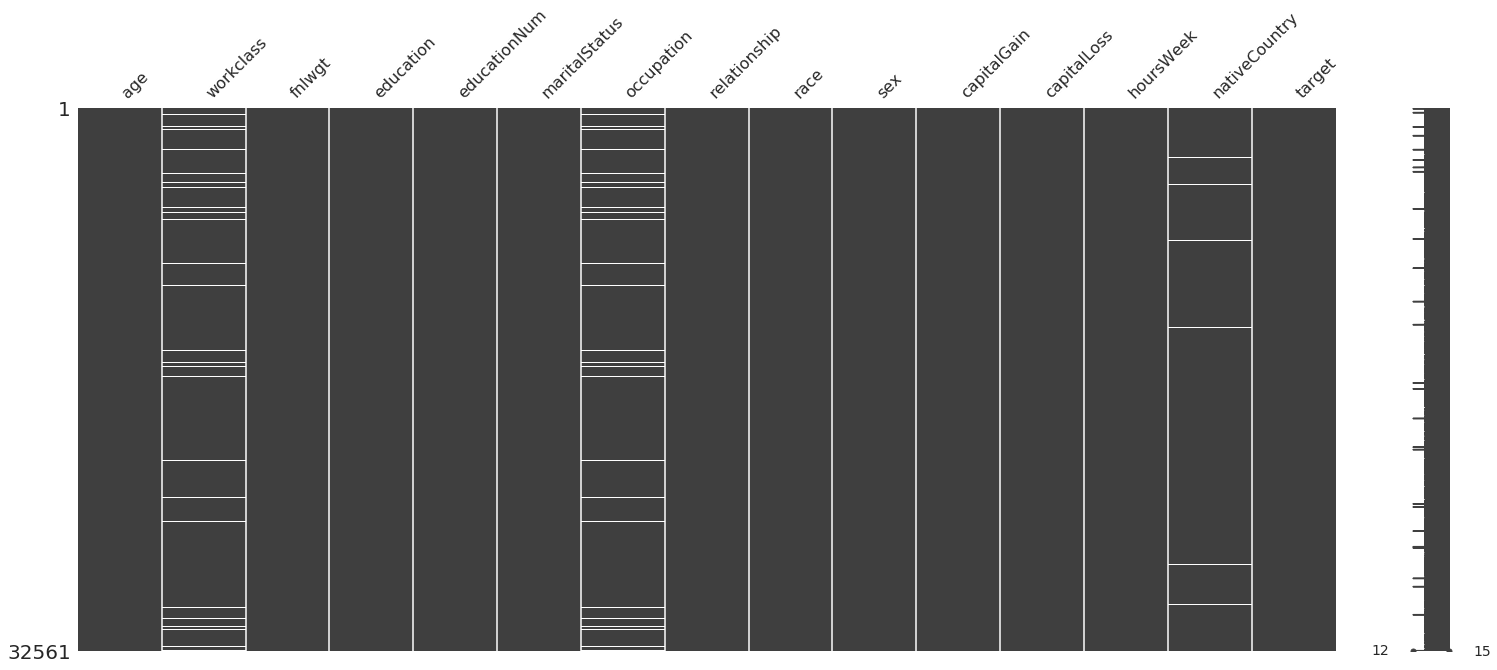

In [77]:
msno.matrix(df_train)

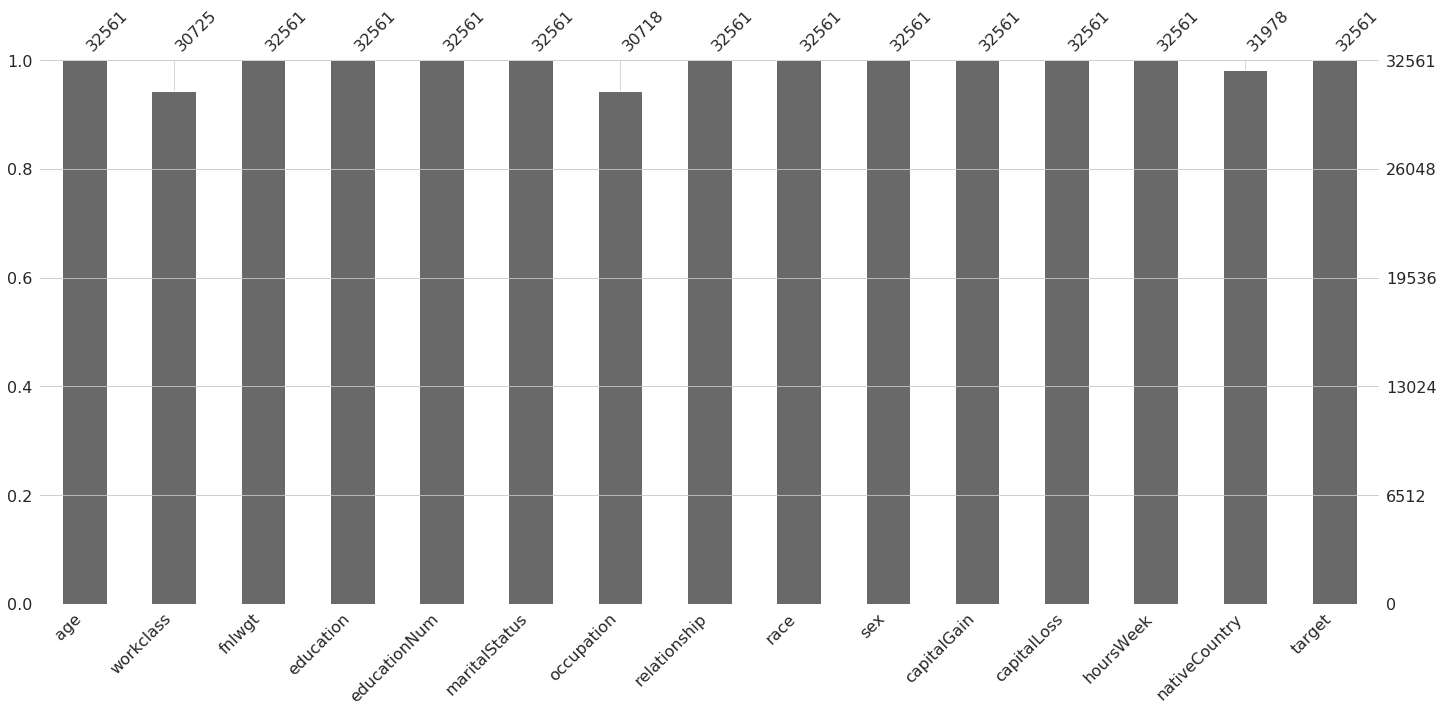

In [78]:
msno.bar(df_train)

In [79]:
df_train.isnull().sum()

age                 0
workclass        1836
fnlwgt              0
education           0
educationNum        0
maritalStatus       0
occupation       1843
relationship        0
race                0
sex                 0
capitalGain         0
capitalLoss         0
hoursWeek           0
nativeCountry     583
target              0
dtype: int64

As we can observe workclass, occupation and native-country features contain missing values 1836, 1843 and 583 values to be exact.

* Workclass and occupation are both considerably important features if we want to predict is someone earns more than 50k

* Native-country is the most delicate feature, due to changing with the median will affect to the dataset. We will try to infer the best age by group or class.

In [80]:
#Drops rows with NaN values
df_train = df_train.dropna()
df_train = df_train.reset_index(drop=True)
df_train.isnull().sum()

age              0
workclass        0
fnlwgt           0
education        0
educationNum     0
maritalStatus    0
occupation       0
relationship     0
race             0
sex              0
capitalGain      0
capitalLoss      0
hoursWeek        0
nativeCountry    0
target           0
dtype: int64

In [81]:
df_train = df_train.drop(['fnlwgt'], axis=1)

## Data skewness


Before moving on to converting the categorical features, we're going to deal with the skewness and outliers from the numeric features:

As we can observe in the above distribution graphs the majority of the features are far from the normal distribution. Moreover, we can observe that some of the features have positive skewness (right) and there is not any negative skewness (left). In orther to achieve a normal distribution in these features we will use the next transformations:
* **Positive skewed features**:
       - Square root tranformation

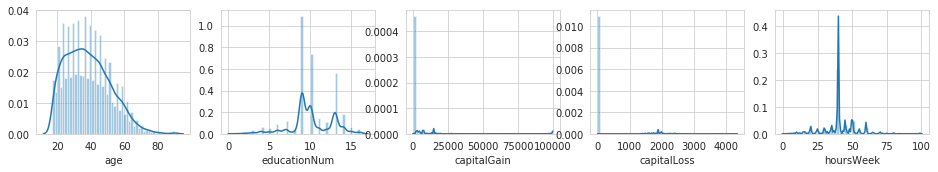

In [82]:
data_columns = df_train._get_numeric_data().columns.values
plot_columns = 7
number_of_columns = math.ceil(len(data_columns)/plot_columns)
number_of_rows = math.ceil((len(data_columns))/number_of_columns)

plt.figure(figsize=(16,5))

# plot distribution
for i in range(0, len(data_columns)):
    plt.subplot(number_of_columns + 1, number_of_rows, i+1)
    sns.distplot(df_train[data_columns[i]], kde=True) 

We are not going to touch 'capitalGain' and 'capitalLoss' because there are too many zeros in both columns, and treating the outliers or skewness would erase whatever data we have with the overwhelming number of zeros we have there. EducationNum is not really a numerical continuous data column, is the numeric code of the type of education held by the Census Bureau, so we are not going to change it.

In [66]:
positively_skewed_cols = ['age', 'hoursWeek']

In [67]:
for col in df_train._get_numeric_data().columns:
    if col in positively_skewed_cols:
        df_train[col] = df_train[col].apply(lambda x : np.sqrt(x)) 

Plot and see it worked:

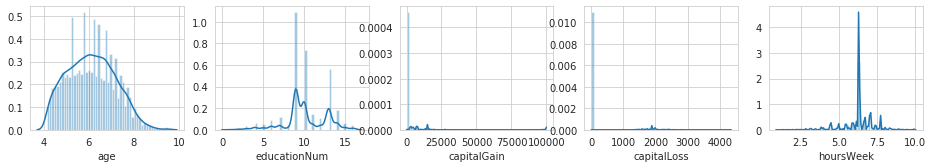

In [68]:
data_columns = df_train._get_numeric_data().columns.values
plot_columns = 7
number_of_columns = math.ceil(len(data_columns)/plot_columns)
number_of_rows = math.ceil((len(data_columns))/number_of_columns)

plt.figure(figsize=(16,5))

# plot distribution
for i in range(0, len(data_columns)):
    plt.subplot(number_of_columns + 1, number_of_rows, i+1)
    sns.distplot(df_train[data_columns[i]], kde=True) 

## Detect Outliers

Only numeric features can be fixed skew and outliers

### Box plots of the data

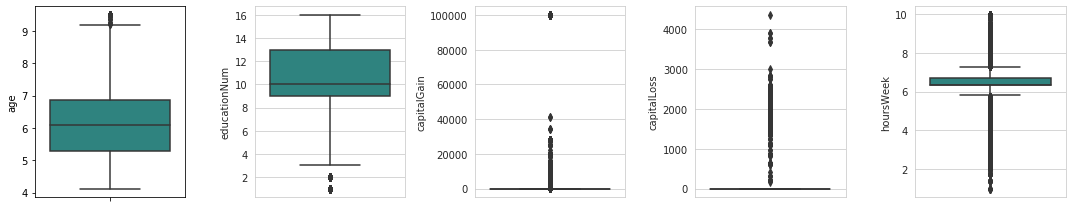

In [18]:
data_columns = df_train._get_numeric_data().columns.values
plot_columns = 7
number_of_columns = math.ceil(len(data_columns)/plot_columns)
number_of_rows = math.ceil((len(data_columns))/number_of_columns)

plt.figure(figsize=(15,3))
for i in range(0,len(data_columns)):
    plt.subplot(number_of_columns, number_of_rows, i+1)
    sns.set_style('whitegrid')
    sns.boxplot(df_train[data_columns[i]],palette='viridis',orient='v')
    plt.tight_layout()

In [19]:
outlier_cols = ['age', 'hoursWeek']

The interquartile range (IQR) is a measure of variability, based on dividing a data set into quartiles.
Quartiles divide a rank-ordered data set into four equal parts. The values that divide each part are called the first, second, and third quartiles; and they are denoted by Q1, Q2, and Q3, respectively.
* Q1 is the "middle" value in the first half of the rank-ordered data set.
* Q2 is the median value in the set.
* Q3 is the "middle" value in the second half of the rank-ordered data set.
The interquartile range (IQR) is equal to Q3 minus Q1.
   * **upperbound** = IQR * 1.5 + Q3 
   * **lowerbound** = IQR * (-1.5) + Q1
If the data is higher than IQR*1.5 + Q3 or lower than the IQR * (-1.5) + Q1 it would be an outlier and we can replace it by the upper or lower bound.

In [20]:
for col in outlier_cols: 
    quartile_1, quartile_3 = np.percentile(df_train[col], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    df_train[col] = np.where(df_train[col] > upper_bound, upper_bound, df_train[col])
    df_train[col] = np.where(df_train[col] < lower_bound, lower_bound, df_train[col])

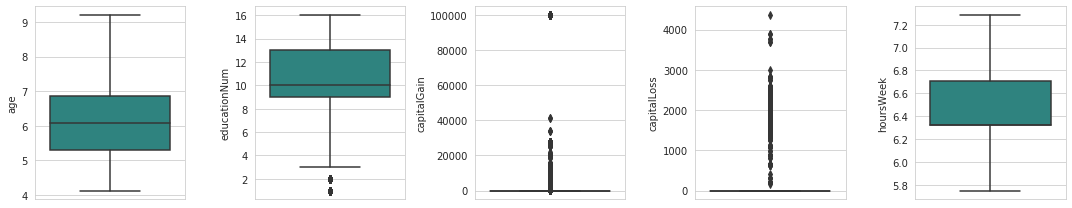

In [21]:
data_columns = df_train._get_numeric_data().columns.values
plot_columns = 7
number_of_columns = math.ceil(len(data_columns)/plot_columns)
number_of_rows = math.ceil((len(data_columns))/number_of_columns)

plt.figure(figsize=(15,3))
for i in range(0,len(data_columns)):
    plt.subplot(number_of_columns, number_of_rows, i+1)
    sns.set_style('whitegrid')
    sns.boxplot(df_train[data_columns[i]],palette='viridis',orient='v')
    plt.tight_layout()

## Convert categorical features<a class="anchor" id="convertion"></a>

If they are not numeric columns then we have to convert the categorical features into something we can measure. If we have categories that are binary (for example, “Sex”) then they can be 0 or 1 and we use LabelEncoder, otherwise we will divide the options and create a column for each option inside a feature that will have a 0 or 1 value.

In [22]:
df_train = df_train.drop(['education'], axis=1)

df_train.select_dtypes(include=['object']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 8 columns):
workclass        30162 non-null object
maritalStatus    30162 non-null object
occupation       30162 non-null object
relationship     30162 non-null object
race             30162 non-null object
sex              30162 non-null object
nativeCountry    30162 non-null object
target           30162 non-null object
dtypes: object(8)
memory usage: 1.8+ MB


In [23]:
le_sex = LabelEncoder()
le_sex.fit(df_train.sex)
df_train['sex'] = le_sex.transform(df_train.sex)

le_target = LabelEncoder()
le_target.fit(df_train.target)
df_train['target'] = le_target.transform(df_train.target)

df_train.head()

,age,workclass,educationNum,maritalStatus,occupation,relationship,race,sex,capitalGain,capitalLoss,hoursWeek,nativeCountry,target
0,6.244998,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,1,2174,0,6.324555,United-States,0
1,7.071068,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,1,0,0,5.749082,United-States,0
2,6.164414,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,1,0,0,6.324555,United-States,0
3,7.280110,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,1,0,0,6.324555,United-States,0
4,5.291503,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,0,0,0,6.324555,Cuba,0


In [24]:
df_train.select_dtypes(include=['object']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 6 columns):
workclass        30162 non-null object
maritalStatus    30162 non-null object
occupation       30162 non-null object
relationship     30162 non-null object
race             30162 non-null object
nativeCountry    30162 non-null object
dtypes: object(6)
memory usage: 1.4+ MB


In [25]:
country = df_train['nativeCountry']
country.unique()

array([' United-States', ' Cuba', ' Jamaica', ' India', ' Mexico',
       ' Puerto-Rico', ' Honduras', ' England', ' Canada', ' Germany',
       ' Iran', ' Philippines', ' Poland', ' Columbia', ' Cambodia',
       ' Thailand', ' Ecuador', ' Laos', ' Taiwan', ' Haiti', ' Portugal',
       ' Dominican-Republic', ' El-Salvador', ' France', ' Guatemala',
       ' Italy', ' China', ' South', ' Japan', ' Yugoslavia', ' Peru',
       ' Outlying-US(Guam-USVI-etc)', ' Scotland', ' Trinadad&Tobago',
       ' Greece', ' Nicaragua', ' Vietnam', ' Hong', ' Ireland',
       ' Hungary', ' Holand-Netherlands'], dtype=object)

In [26]:
country.value_counts()

 United-States                 27504
 Mexico                          610
 Philippines                     188
 Germany                         128
 Puerto-Rico                     109
 Canada                          107
 El-Salvador                     100
 India                           100
 Cuba                             92
 England                          86
 Jamaica                          80
 South                            71
 China                            68
 Italy                            68
 Dominican-Republic               67
 Vietnam                          64
 Guatemala                        63
 Japan                            59
 Columbia                         56
 Poland                           56
 Haiti                            42
 Taiwan                           42
 Iran                             42
 Portugal                         34
 Nicaragua                        33
 Peru                             30
 Greece                           29
 

In [27]:
df_no_country = df_train.drop(['nativeCountry'], axis=1)

### Workclass

In [28]:
df_train.describe(include='O')

,workclass,maritalStatus,occupation,relationship,race,nativeCountry
count,30162,30162,30162,30162,30162,30162
unique,7,7,14,6,5,41
top,Private,Married-civ-spouse,Prof-specialty,Husband,White,United-States
freq,22286,14065,4038,12463,25933,27504


In [29]:
df_train['workclass'].value_counts()

 Private             22286
 Self-emp-not-inc     2499
 Local-gov            2067
 State-gov            1279
 Self-emp-inc         1074
 Federal-gov           943
 Without-pay            14
Name: workclass, dtype: int64

In [30]:
col_n = 'workclass'
my_size = ' Without-pay'
df_no_volunteers = df_no_country.query("{0} != '{1}'".format(col_n, my_size))
df_no_volunteers['workclass'].value_counts()

df_no_volunteers.isnull().sum()

age              0
workclass        0
educationNum     0
maritalStatus    0
occupation       0
relationship     0
race             0
sex              0
capitalGain      0
capitalLoss      0
hoursWeek        0
target           0
dtype: int64

In [31]:
workclass_dictionary = {
    " Private": "Private",
    " Self-emp-not-inc": "Self-employed",
    " Self-emp-inc": "Self-employed",
    " Federal-gov": "Government",
    " Local-gov": "Government",
    " State-gov" : "Government"
}

In [32]:
# a map of more aggregated title
# we map each title
df_no_volunteers['workclass'] = df_no_volunteers.workclass.map(workclass_dictionary)
df_no_volunteers.head()

df_no_volunteers.isnull().sum()

age              0
workclass        0
educationNum     0
maritalStatus    0
occupation       0
relationship     0
race             0
sex              0
capitalGain      0
capitalLoss      0
hoursWeek        0
target           0
dtype: int64

In [33]:
df_workclass = pd.get_dummies(df_no_volunteers.workclass)
df_train_workclass = pd.concat([df_no_volunteers, df_workclass],axis=1)

#Erase title from df
df_train_workclass = df_train_workclass.drop(['workclass'], axis=1)
df_train_workclass.head()
df_train_workclass.isnull().sum()

age              0
educationNum     0
maritalStatus    0
occupation       0
relationship     0
race             0
sex              0
capitalGain      0
capitalLoss      0
hoursWeek        0
target           0
Government       0
Private          0
Self-employed    0
dtype: int64

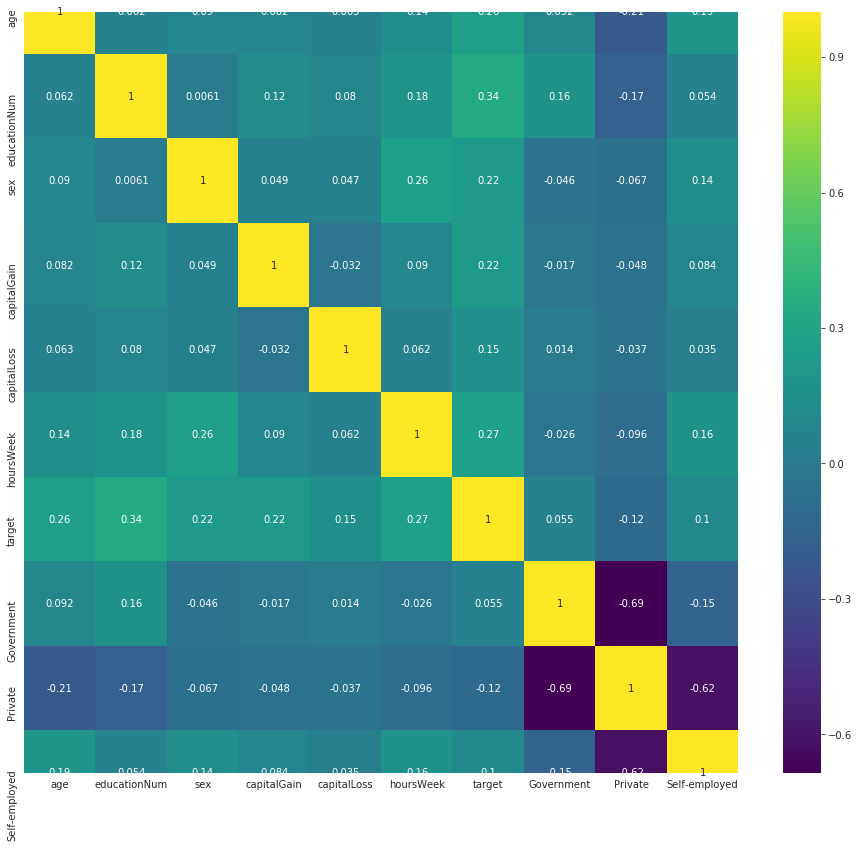

In [34]:
corr = df_train_workclass.corr()
plt.figure(figsize=(16,14))
sns.heatmap(corr, annot=True, cmap = 'viridis')

In [35]:
df_train_workclass

,age,educationNum,maritalStatus,occupation,relationship,race,sex,capitalGain,capitalLoss,hoursWeek,target,Government,Private,Self-employed
0,6.244998,13,Never-married,Adm-clerical,Not-in-family,White,1,2174,0,6.324555,0,1,0,0
1,7.071068,13,Married-civ-spouse,Exec-managerial,Husband,White,1,0,0,5.749082,0,0,0,1
2,6.164414,9,Divorced,Handlers-cleaners,Not-in-family,White,1,0,0,6.324555,0,0,1,0
3,7.280110,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,1,0,0,6.324555,0,0,1,0
4,5.291503,13,Married-civ-spouse,Prof-specialty,Wife,Black,0,0,0,6.324555,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,5.196152,12,Married-civ-spouse,Tech-support,Wife,White,0,0,0,6.164414,0,0,1,0
30158,6.324555,9,Married-civ-spouse,Machine-op-inspct,Husband,White,1,0,0,6.324555,1,0,1,0
30159,7.615773,9,Widowed,Adm-clerical,Unmarried,White,0,0,0,6.324555,0,0,1,0
30160,4.690416,9,Never-married,Adm-clerical,Own-child,White,1,0,0,5.749082,0,0,1,0


## MaritalStatus

In [36]:
maritalStatus = df_train['maritalStatus']
maritalStatus.unique()

array([' Never-married', ' Married-civ-spouse', ' Divorced',
       ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
       ' Widowed'], dtype=object)

In [37]:
df_train['maritalStatus'].value_counts()

 Married-civ-spouse       14065
 Never-married             9726
 Divorced                  4214
 Separated                  939
 Widowed                    827
 Married-spouse-absent      370
 Married-AF-spouse           21
Name: maritalStatus, dtype: int64

In [38]:
maritalStatus_dictionary = {
    " Married-civ-spouse": "Married",
    " Married-spouse-absent": "Married",
    " Married-AF-spouse": "Married",
    " Never-married": "Single",
    " Divorced": "Divorced",
    " Separated" : "Separated",
    " Widowed" :  "Widowed"
}
df_train_workclass['maritalStatus'] = df_train_workclass.maritalStatus.map(maritalStatus_dictionary)
df_train_workclass.head()

,age,educationNum,maritalStatus,occupation,relationship,race,sex,capitalGain,capitalLoss,hoursWeek,target,Government,Private,Self-employed
0,6.244998,13,Single,Adm-clerical,Not-in-family,White,1,2174,0,6.324555,0,1,0,0
1,7.071068,13,Married,Exec-managerial,Husband,White,1,0,0,5.749082,0,0,0,1
2,6.164414,9,Divorced,Handlers-cleaners,Not-in-family,White,1,0,0,6.324555,0,0,1,0
3,7.280110,7,Married,Handlers-cleaners,Husband,Black,1,0,0,6.324555,0,0,1,0
4,5.291503,13,Married,Prof-specialty,Wife,Black,0,0,0,6.324555,0,0,1,0


In [39]:
df_maritalStatus = pd.get_dummies(df_train_workclass.maritalStatus)
df_train_maritalStatus = pd.concat([df_train_workclass, df_maritalStatus],axis=1)

#Erase title from df
df_train_maritalStatus = df_train_maritalStatus.drop(['maritalStatus'], axis=1)
df_train_maritalStatus
df_train_maritalStatus.isnull().sum()

age              0
educationNum     0
occupation       0
relationship     0
race             0
sex              0
capitalGain      0
capitalLoss      0
hoursWeek        0
target           0
Government       0
Private          0
Self-employed    0
Divorced         0
Married          0
Separated        0
Single           0
Widowed          0
dtype: int64

## Occupation       

In [40]:
df_train_maritalStatus['occupation'].value_counts()

 Prof-specialty       4038
 Craft-repair         4029
 Exec-managerial      3992
 Adm-clerical         3718
 Sales                3584
 Other-service        3211
 Machine-op-inspct    1965
 Transport-moving     1571
 Handlers-cleaners    1349
 Farming-fishing       983
 Tech-support          912
 Protective-serv       644
 Priv-house-serv       143
 Armed-Forces            9
Name: occupation, dtype: int64

In [41]:
df_occupation = pd.get_dummies(df_train_maritalStatus.occupation)
df_train_occupation = pd.concat([df_train_maritalStatus, df_occupation],axis=1)

#Erase title from df
df_train_occupation = df_train_occupation.drop(['occupation'], axis=1)
df_train_occupation

,age,educationNum,relationship,race,sex,capitalGain,capitalLoss,hoursWeek,target,Government,...,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
0,6.244998,13,Not-in-family,White,1,2174,0,6.324555,0,1,...,0,0,0,0,0,0,0,0,0,0
1,7.071068,13,Husband,White,1,0,0,5.749082,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6.164414,9,Not-in-family,White,1,0,0,6.324555,0,0,...,0,1,0,0,0,0,0,0,0,0
3,7.280110,7,Husband,Black,1,0,0,6.324555,0,0,...,0,1,0,0,0,0,0,0,0,0
4,5.291503,13,Wife,Black,0,0,0,6.324555,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,5.196152,12,Wife,White,0,0,0,6.164414,0,0,...,0,0,0,0,0,0,0,0,1,0
30158,6.324555,9,Husband,White,1,0,0,6.324555,1,0,...,0,0,1,0,0,0,0,0,0,0
30159,7.615773,9,Unmarried,White,0,0,0,6.324555,0,0,...,0,0,0,0,0,0,0,0,0,0
30160,4.690416,9,Own-child,White,1,0,0,5.749082,0,0,...,0,0,0,0,0,0,0,0,0,0


## Race             

In [42]:
df_train_occupation['race'].value_counts()

 White                 25921
 Black                  2816
 Asian-Pac-Islander      894
 Amer-Indian-Eskimo      286
 Other                   231
Name: race, dtype: int64

In [53]:
df_race = pd.get_dummies(df_train_occupation.race)
df_train_race = pd.concat([df_train_occupation, df_race],axis=1)

#Erase title from df
df_train_race = df_train_race.drop(['race'], axis=1)
df_train_race

,age,educationNum,relationship,sex,capitalGain,capitalLoss,hoursWeek,target,Government,Private,...,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
0,6.244998,13,Not-in-family,1,2174,0,6.324555,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,7.071068,13,Husband,1,0,0,5.749082,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,6.164414,9,Not-in-family,1,0,0,6.324555,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,7.280110,7,Husband,1,0,0,6.324555,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,5.291503,13,Wife,0,0,0,6.324555,0,0,1,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,5.196152,12,Wife,0,0,0,6.164414,0,0,1,...,0,0,0,1,0,0,0,0,0,1
30158,6.324555,9,Husband,1,0,0,6.324555,1,0,1,...,0,0,0,0,0,0,0,0,0,1
30159,7.615773,9,Unmarried,0,0,0,6.324555,0,0,1,...,0,0,0,0,0,0,0,0,0,1
30160,4.690416,9,Own-child,1,0,0,5.749082,0,0,1,...,0,0,0,0,0,0,0,0,0,1


## Relationship

In [54]:
df_train_race['relationship'].value_counts()

 Husband           12459
 Not-in-family      7726
 Own-child          4461
 Unmarried          3210
 Wife               1403
 Other-relative      889
Name: relationship, dtype: int64

In [55]:
df_relationship = pd.get_dummies(df_train_race.relationship)
df_train_relationship = pd.concat([df_train_race, df_relationship],axis=1)

#Erase title from df
df_train_relationship = df_train_relationship.drop(['relationship'], axis=1)
df_train_relationship

,age,educationNum,sex,capitalGain,capitalLoss,hoursWeek,target,Government,Private,Self-employed,...,Asian-Pac-Islander,Black,Other,White,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
0,6.244998,13,1,2174,0,6.324555,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0
1,7.071068,13,1,0,0,5.749082,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
2,6.164414,9,1,0,0,6.324555,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
3,7.280110,7,1,0,0,6.324555,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
4,5.291503,13,0,0,0,6.324555,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,5.196152,12,0,0,0,6.164414,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
30158,6.324555,9,1,0,0,6.324555,1,0,1,0,...,0,0,0,1,1,0,0,0,0,0
30159,7.615773,9,0,0,0,6.324555,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
30160,4.690416,9,1,0,0,5.749082,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0


## **Feature selection<a class="anchor" id="featureselection"></a>**

First we separate the target and the rest of the dataset

In [56]:
X = df_train_relationship.drop('target', axis=1)

In [57]:
y = df_train_relationship['target']

For the feature selection part we are going to try different methods:
* Feature importances of tree based classifiers.
* Univariate analysis taking into account the chi squared statistical test.


### Feature importance of tree based classifiers

[2.59927788e-01 1.39240635e-01 1.44019718e-02 9.03066754e-02
 3.01743912e-02 9.31331929e-02 6.37340033e-03 8.01584983e-03
 6.88684112e-03 9.31098521e-03 7.38158654e-02 2.54641624e-03
 3.47773066e-02 1.81534365e-03 4.49718213e-03 3.42262100e-05
 6.58738079e-03 3.03446372e-02 5.74285760e-03 3.98257567e-03
 4.73193738e-03 1.03213868e-02 2.13879691e-04 2.62670090e-02
 2.64638784e-03 6.81083764e-03 4.90187791e-03 4.48824869e-03
 1.91661792e-03 4.03309553e-03 4.99774488e-03 1.26687820e-03
 6.40052184e-03 5.13044781e-02 1.26574928e-02 2.04922241e-03
 1.13621236e-02 6.42110809e-03 1.52936292e-02]


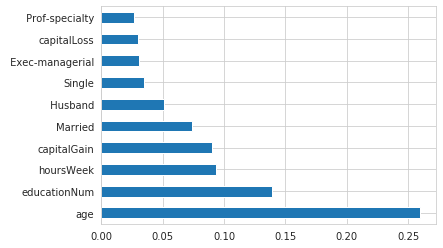

In [58]:
model = ExtraTreesClassifier()
model.fit(X, y)

#use inbuilt class feature_importances of tree based classifiers
print(model.feature_importances_) 

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

plt.show()
selected_trees = feat_importances.nlargest(10).keys()

### CHI Squared Test

In [59]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func = chi2, k=10)
fit = bestfeatures.fit(X, y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features
selected_chi2 = featureScores.nlargest(10,'Score').Specs

               Specs         Score
3        capitalGain  7.410595e+07
4        capitalLoss  1.254731e+06
10           Married  2.989728e+03
33           Husband  2.848420e+03
1       educationNum  2.177106e+03
12            Single  2.093829e+03
36         Own-child  1.313843e+03
17   Exec-managerial  1.190698e+03
23    Prof-specialty  8.589270e+02
34     Not-in-family  8.390543e+02


In [50]:
print(selected_trees)

Index(['age', 'educationNum', 'hoursWeek', 'capitalGain', 'Married',
       ' Husband', 'capitalLoss', ' Exec-managerial', 'Single',
       ' Prof-specialty'],
      dtype='object')


In [51]:
print(selected_chi2)

3          capitalGain
4          capitalLoss
10             Married
33             Husband
1         educationNum
12              Single
36           Own-child
17     Exec-managerial
23      Prof-specialty
34       Not-in-family
Name: Specs, dtype: object


We create the new X dataframe from the result. Finally we selected tree method.

In [61]:
importantCols=selected_trees

In [98]:
X_fs = X[importantCols]
X_fs

,age,educationNum,Married,hoursWeek,capitalGain,Husband,capitalLoss,Exec-managerial,Prof-specialty,Wife
0,6.244998,13,0,6.324555,2174,0,0,0,0,0
1,7.071068,13,1,5.749082,0,1,0,1,0,0
2,6.164414,9,0,6.324555,0,0,0,0,0,0
3,7.280110,7,1,6.324555,0,1,0,0,0,0
4,5.291503,13,1,6.324555,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
30157,5.196152,12,1,6.164414,0,0,0,0,0,1
30158,6.324555,9,1,6.324555,0,1,0,0,0,0
30159,7.615773,9,0,6.324555,0,0,0,0,0,0
30160,4.690416,9,0,5.749082,0,0,0,0,0,0


## **Testing dataset**

The following code does everything we've done to the training dataset to prepare it to use it for the models.

In [66]:
df_test = pd.read_csv('adult_test.csv')
df_test = df_test.replace(' ?', np.nan)
df_test = df_test.dropna()
df_test = df_test.reset_index(drop=True)
df_test = df_test.drop(['fnlwgt'], axis=1)

#categorical labeling
df_test = df_test.drop(['education'], axis=1)
le_sex = LabelEncoder()
le_sex.fit(df_test.sex)
df_test['sex'] = le_sex.transform(df_test.sex)

le_target = LabelEncoder()
le_target.fit(df_test.target)
df_test['target'] = le_target.transform(df_test.target)

df_no_country_test = df_test.drop(['nativeCountry'], axis=1)

col_n = 'workclass'
my_size = ' Without-pay'
df_no_volunteers_test = df_no_country_test.query("{0} != '{1}'".format(col_n, my_size))
df_no_volunteers_test['workclass'].value_counts()

maritalStatus_dictionary = {
    " Married-civ-spouse": "Married",
    " Married-spouse-absent": "Married",
    " Married-AF-spouse": "Married",
    " Never-married": "Single",
    " Divorced": "Divorced",
    " Separated" : "Separated",
    " Widowed" :  "Widowed"
}

workclass_dictionary = {
    " Private": "Private",
    " Self-emp-not-inc": "Self-employed",
    " Self-emp-inc": "Self-employed",
    " Federal-gov": "Government",
    " Local-gov": "Government",
    " State-gov" : "Government"
}

df_no_volunteers_test['workclass'] = df_no_volunteers_test.workclass.map(workclass_dictionary)
df_workclass_test = pd.get_dummies(df_no_volunteers_test.workclass)
df_train_workclass_test = pd.concat([df_no_volunteers_test, df_workclass_test],axis=1)
df_train_workclass_test = df_train_workclass_test.drop(['workclass'], axis=1)

df_train_workclass_test['maritalStatus'] = df_train_workclass_test.maritalStatus.map(maritalStatus_dictionary)
df_maritalStatus_test = pd.get_dummies(df_train_workclass_test.maritalStatus)
df_train_maritalStatus_test = pd.concat([df_train_workclass_test, df_maritalStatus_test],axis=1)
df_train_maritalStatus_test = df_train_maritalStatus_test.drop(['maritalStatus'], axis=1)

df_occupation_test = pd.get_dummies(df_train_maritalStatus_test.occupation)
df_train_occupation_test = pd.concat([df_train_maritalStatus_test, df_occupation_test],axis=1)
df_train_occupation_test = df_train_occupation_test.drop(['occupation'], axis=1)

df_race_test = pd.get_dummies(df_train_occupation_test.race)
df_train_race_test = pd.concat([df_train_occupation_test, df_race_test],axis=1)
df_train_race_test = df_train_race_test.drop(['race'], axis=1)

df_relationship_test = pd.get_dummies(df_train_race_test.relationship)
df_train_relationship_test = pd.concat([df_train_race_test, df_relationship_test],axis=1)

#Erase title from df
df_test_final = df_train_relationship_test.drop(['relationship'], axis=1)

df_test_final.head()
##probar con esto sino se tienen que modificar age y hoursWeek como positively skewed como el train dataset

,age,educationNum,sex,capitalGain,capitalLoss,hoursWeek,target,Government,Private,Self-employed,...,Asian-Pac-Islander,Black,Other,White,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
0,25,7,1,0,0,40,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
1,38,9,1,0,0,50,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0
2,28,12,1,0,0,40,1,1,0,0,...,0,0,0,1,1,0,0,0,0,0
3,44,10,1,7688,0,40,1,0,1,0,...,0,1,0,0,1,0,0,0,0,0
4,34,6,1,0,0,30,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0


# **Resample method**

The resampling protocol that we used:

We decided to use a **K-Folds Cross Validation**. We must assure that our model got the correct patterns from the data, and it is not getting up too much noise so in an effort to do so we use this method in which we split the dataset into k number of subsets(or folds) then we perform training on all the subsets but leave one (k-1) subset for the evaluation of the trained model. 

**K-Folds Cross Validation**

In [128]:
aux = pd.concat([X_fs,y],axis=1)
aux

,age,educationNum,Married,hoursWeek,capitalGain,Husband,capitalLoss,Exec-managerial,Prof-specialty,Wife,target
0,6.244998,13,0,6.324555,2174,0,0,0,0,0,0
1,7.071068,13,1,5.749082,0,1,0,1,0,0,0
2,6.164414,9,0,6.324555,0,0,0,0,0,0,0
3,7.280110,7,1,6.324555,0,1,0,0,0,0,0
4,5.291503,13,1,6.324555,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
30157,5.196152,12,1,6.164414,0,0,0,0,0,1,0
30158,6.324555,9,1,6.324555,0,1,0,0,0,0,1
30159,7.615773,9,0,6.324555,0,0,0,0,0,0,0
30160,4.690416,9,0,5.749082,0,0,0,0,0,0,0


In [133]:
from sklearn.model_selection import KFold # import KFold
kf = KFold(n_splits=2, random_state=42, shuffle=False) # Define the split - into 2 folds 
result = next(kf.split(aux), None)
print(result)

(array([15074, 15075, 15076, ..., 30145, 30146, 30147]), array([    0,     1,     2, ..., 15071, 15072, 15073]))


Now we create the trainning and test sets from the result of Cross Validation

In [134]:
#Using feature selection
X_train = X_fs.iloc[result[0]]
X_test =  X_fs.iloc[result[1]]
y_train = y.iloc[result[0]]
y_test =  y.iloc[result[1]]

#Not using feature selection
#X_train = X.iloc[result[0]]
#X_test =  X.iloc[result[1]]

# **Linear/quadratic models**

The results obtained using three linear/quadratic methods (indicating the best set of
parameters for each one):

** logistic regression
** k nearest-neighbours
** linear SVM (dijo que coger este y luego el que tiene el kerne de RBF nos daria una comparativa guay )

**Logistic Regression**

In [135]:
lm = LogisticRegression(solver='lbfgs', max_iter=10)
lm.fit(X_train, y_train)
print(lm.score(X_test, y_test))

0.7747777630356906


Predicted,0,1
Actual,,
0,10528,821
1,2574,1151


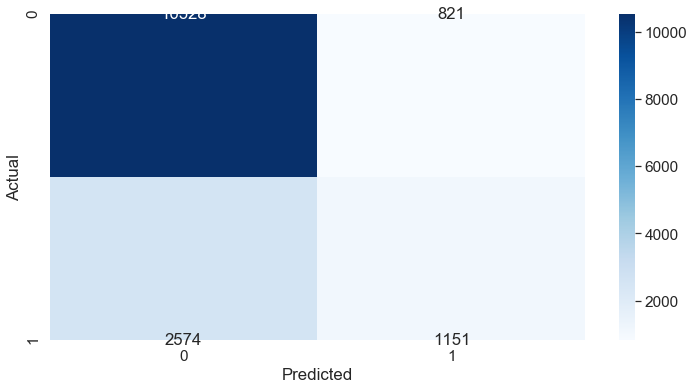

In [136]:
y_pred_LR = lm.predict(X_test)
confusionMatrix(y_test, y_pred_LR)

**k nearest-neighbours**

The principle behind nearest neighbor methods is to find a predefined number of training samples closest in distance to the new point, and predict the label from these. The number of samples can be a user-defined constant (k-nearest neighbor learning), or vary based on the local density of points (radius-based neighbor learning). The distance can, in general, be any metric measure: standard Euclidean distance is the most common choice. 

In [116]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.8393923311662466


Predicted,0,1
Actual,,
0,10847,502
1,1919,1806


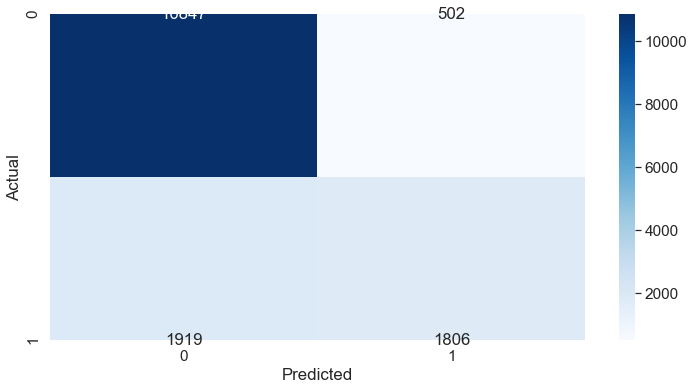

In [117]:
y_pred_KNN = knn.predict(X_test)
confusionMatrix(y_test, y_pred_KNN)

***Linear SVM***

Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.

In [118]:
svmlineal = LinearSVC(C=0.01, penalty="l1", dual=False)
svmlineal.fit(X_train, y_train)
print(svmlineal.score(X_test, y_test))

0.8403210826588828


Predicted,0,1
Actual,,
0,10715,634
1,1773,1952


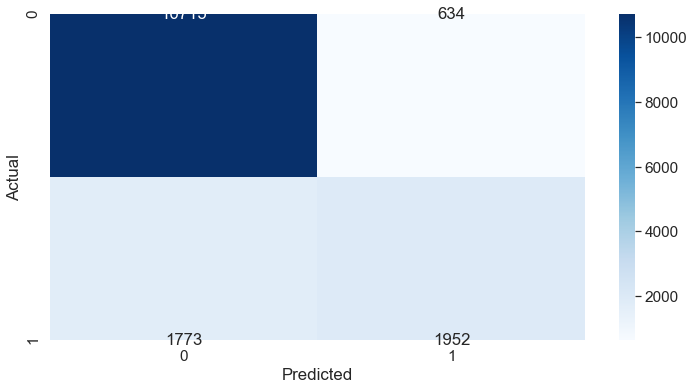

In [119]:
y_pred_lsvm = svmlineal.predict(X_test)
confusionMatrix(y_test, y_pred_lsvm)

# **Non-linear models**


**SVM with RBF kernel**

The advantages of support vector machines are: They're effective in high dimensional spaces. Still effective in cases where number of dimensions is greater than the number of samples. Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient. They're also versatile and have different Kernel functions can be specified for the decision function.

In [120]:
svmrbf = SVC(kernel='rbf', random_state=0, gamma=.01, C=1)
svmrbf.fit(X_train, y_train)
print(svmrbf.score(X_test, y_test))

0.8559108398567069


Predicted,0,1
Actual,,
0,10753,596
1,1576,2149


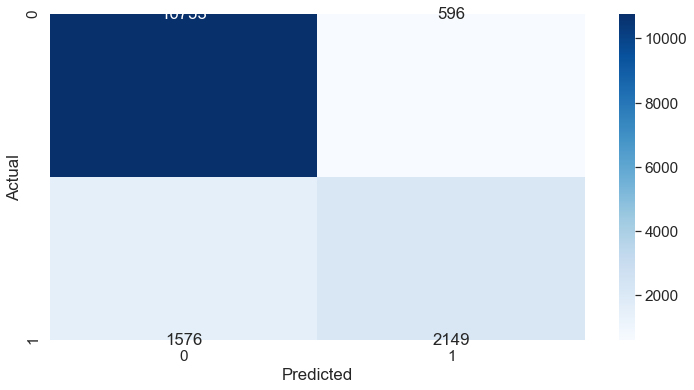

In [121]:
y_pred_rbf = svmrbf.predict(X_test)
confusionMatrix(y_test, y_pred_rbf)

In [ ]:
#testing another parameters
svmrbf = SVC(kernel='rbf', random_state=0, gamma=.01, C=1)
svmrbf.fit(X_train, y_train)
print(svmrbf.score(X_test, y_test))

y_pred_rbf = svmrbf.predict(X_test)
confusionMatrix(y_test, y_pred_rbf)

**Random Forest**

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

In [122]:
rf = RandomForestClassifier(n_estimators = 10, max_depth=5, random_state = 0)
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))

0.8460926097916943


Predicted,0,1
Actual,,
0,10853,496
1,1824,1901


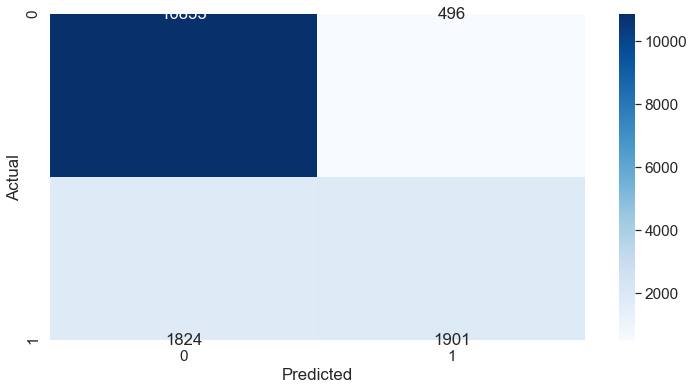

In [123]:
y_pred_rf = rf.predict(X_test)
confusionMatrix(y_test, y_pred_rf)

# **Final Model**

Finally, our final model is **SVM with RBF kernel** because is the model whose score is greater than the other models that we tested. Now we will process the testing dataset with this model.

In [124]:
X_test_final = X = df_test_final.drop('target', axis=1)

In [125]:
y_test_final = df_test_final['target']

In [126]:
svmrbf = SVC(kernel='rbf', random_state=0, gamma=.01, C=1)
svmrbf.fit(X_test_final, y_test_final)
print(svmrbf.score(X_test_final, y_test_final))

0.8665382315817445


Predicted,0,1
Actual,,
0,10973,382
1,1627,2071


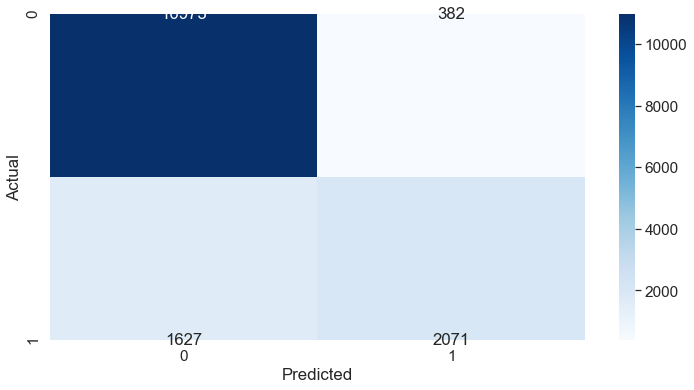

In [127]:
y_pred_final = svmrbf.predict(X_test_final)
confusionMatrix(y_test_final, y_pred_final)

The final model has a score = 0.8665382315817445, so we can conclude that it is a good model for our classification problem.